## 0. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn import preprocessing


from tqdm import tqdm

/home/ubuntu/anaconda3/envs/py38mj/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 1. data preprocessing

### 1) open dataset

In [2]:
file_path = "./dataset_new/"

In [3]:
# 원본 data 부르기
retail_data = pd.read_csv(f"{file_path}Retail data.csv")
industry_data = pd.read_csv(f"{file_path}Industry data.csv")
dealer_hierarchies = pd.read_csv(f"{file_path}Dealer_Hierarchies.csv")

### 2) dataset에 행, 열 통합

- retail, industry data에 지역 정보를 추가한다

In [4]:
# Month가 datetime 형식으로 되어있는데, 이를 필요한 데이터만 얻기 위하여 분리
# datetime 형변환
retail_data["Month"] = pd.to_datetime(retail_data["Month"], format="%Y-%m-%d %H:%M:%S")
industry_data["Month"] = pd.to_datetime(industry_data["Month"], format="%Y-%m-%d %H:%M:%S")

# 열 이름 변경
retail_data.rename(columns={"Month": "Datetime"}, inplace=True)
retail_data.info()

industry_data.rename(columns={"Month": "Datetime"}, inplace=True)
industry_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125226 entries, 0 to 125225
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Datetime      125226 non-null  datetime64[ns]
 1   Sales Total   125226 non-null  int64         
 2   Store         125226 non-null  int64         
 3   Product Type  125226 non-null  object        
 4   Item          125226 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 4.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352894 entries, 0 to 352893
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Datetime       352894 non-null  datetime64[ns]
 1   Industry Size  352894 non-null  int64         
 2   Store          352894 non-null  int64         
 3   Product Type   352894 non-null  object        
 4   Item           352894 non-null  objec

In [5]:
retail_data["Year"] = retail_data["Datetime"].dt.year
retail_data["Month"] = retail_data["Datetime"].dt.month
retail_data["Day"] = retail_data["Datetime"].dt.day
retail_data["Time"] = retail_data["Datetime"].dt.time

industry_data["Year"] = industry_data["Datetime"].dt.year
industry_data["Month"] = industry_data["Datetime"].dt.month
industry_data["Day"] = industry_data["Datetime"].dt.day
industry_data["Time"] = industry_data["Datetime"].dt.time

- day와 time은 필요 없는 값 (1일과 0시만 존재)
- Year, month만 선택해서 datetime을 만들 때 기본 1일 0시로 들어가게 된다

In [167]:
# column 선택
retail_data = retail_data[["Sales Total", "Store", "Product Type", "Item", "Year", "Month", "Datetime"]]
industry_data = industry_data[["Industry Size", "Store", "Product Type", "Item", "Year", "Month", "Datetime"]]

- Store 정보를 추가한다

In [168]:
# retail
region_lv1 = []
region_lv2 = []
urban_rural = []

for i in tqdm(range(len(retail_data))):
    store_num = retail_data.loc[i]["Store"]
    idx = store_num - 1
    region_lv1.append(dealer_hierarchies.loc[idx]["Region Level 1"])
    region_lv2.append(dealer_hierarchies.loc[idx]["Region Level 2"])
    urban_rural.append(dealer_hierarchies.loc[idx]["Urban/Rural"])

retail_data["Region Level 1"] = region_lv1
retail_data["Region Level 2"] = region_lv2
retail_data["Urban/Rural"] = urban_rural

100%|██████████| 125226/125226 [00:51<00:00, 2412.11it/s]


In [169]:
# industry
region_lv1 = []
region_lv2 = []
urban_rural = []

for i in tqdm(range(len(industry_data))):
    store_num = industry_data.loc[i]["Store"]
    idx = store_num - 1
    region_lv1.append(dealer_hierarchies.loc[idx]["Region Level 1"])
    region_lv2.append(dealer_hierarchies.loc[idx]["Region Level 2"])
    urban_rural.append(dealer_hierarchies.loc[idx]["Urban/Rural"])

industry_data["Region Level 1"] = region_lv1
industry_data["Region Level 2"] = region_lv2
industry_data["Urban/Rural"] = urban_rural

100%|██████████| 352894/352894 [02:27<00:00, 2386.15it/s]


In [170]:
# 2)에 대한 중간저장과 불러오기를 진행
# *** 나중에 주석 풀어야함 ***
# retail_data.to_csv(f"{file_path}Retail_data_add_region.csv", index=False)
# industry_data.to_csv(f"{file_path}Industry_data_add_region.csv", index=False)

retail_data_ar= pd.read_csv(f"{file_path}Retail_data_add_region.csv")
industry_data_ar = pd.read_csv(f"{file_path}Industry_data_add_region.csv")

### 3) 이상치 제거

- 이상치 (industry < retail)의 경우 모두 0으로 변경한다
- 큰 값으로 맞춰주는 것보다 0으로 변경하는 것의 예측 결과가 더 좋았음

- industry data > retail data 를 확인하기 위해서 store-item-Datetime 열을 생성한다

In [171]:
retail_si = []
for i in tqdm(range(len(retail_data_ar))):
    store = retail_data_ar.loc[i]['Store']
    item = retail_data_ar.loc[i]['Item']
    year = retail_data_ar.loc[i]["Year"]
    month = retail_data_ar.loc[i]["Month"]
    retail_si.append(f'{store}-{item}-{year}-{month}')

100%|██████████| 125226/125226 [00:50<00:00, 2502.07it/s]


In [172]:
retail_data_ar['StoreItem'] = retail_si

In [173]:
industry_si = []
for i in tqdm(range(len(industry_data_ar))):
    store = industry_data_ar.loc[i]['Store']
    item = industry_data_ar.loc[i]['Item']
    year = industry_data_ar.loc[i]["Year"]
    month = industry_data_ar.loc[i]["Month"]
    industry_si.append(f'{store}-{item}-{year}-{month}')
    

100%|██████████| 352894/352894 [02:20<00:00, 2513.04it/s]


In [174]:
industry_data_ar['StoreItem'] = industry_si

In [175]:
retail_err_idx = []
industry_err_idx = []

In [176]:
for i in tqdm(range(len(retail_data_ar))):
    storeitem = retail_data_ar.loc[i]['StoreItem']
    same_item_df = industry_data_ar[industry_data_ar['StoreItem']==storeitem]
    if len(same_item_df) == 0:
        retail_err_idx.append(i)
        continue
    
    if same_item_df.iloc[0]['Industry Size'] < retail_data_ar.loc[i]["Sales Total"]: # Sales total이 더 크면 error
        retail_err_idx.append(i)
        industry_err_idx.append(same_item_df.index[0])

100%|██████████| 125226/125226 [47:22<00:00, 44.06it/s]


In [177]:
print(len(retail_err_idx))
print(len(industry_err_idx))

23401
4205


In [178]:
# ***
# with open('retail_err_idx.pkl','wb') as f:
#     pickle.dump(retail_err_idx,f)
# with open('industry_err_idx.pkl','wb') as f:
#     pickle.dump(industry_err_idx,f)

with open('retail_err_idx.pkl','rb') as f:
    retail_err_idx = pickle.load(f)
with open('industry_err_idx.pkl', 'rb') as f:
    industry_err_idx = pickle.load(f)

In [179]:
# label 을 없앤다
retail_data_ar_delidx = retail_data_ar.drop(retail_err_idx).reset_index(drop=True)
industry_data_ar_delidx = industry_data_ar.drop(industry_err_idx).reset_index(drop=True)

In [180]:
retail_data_ar_delidx['Store'] = retail_data_ar_delidx['Store'].astype(str)
industry_data_ar_delidx['Store'] = industry_data_ar_delidx['Store'].astype(str)

In [181]:
retail_data_ar_delidx = retail_data_ar_delidx[['Sales Total','Store', 'Product Type', 'Item','Year','Month','Datetime','Region Level 1','Region Level 2','Urban/Rural']]
industry_data_ar_delidx = industry_data_ar_delidx[['Industry Size','Store', 'Product Type', 'Item','Year','Month','Datetime','Region Level 1','Region Level 2','Urban/Rural']]


In [182]:
retail_data_ar_delidx.head(3)

,Sales Total,Store,Product Type,Item,Year,Month,Datetime,Region Level 1,Region Level 2,Urban/Rural
0,1,1,Electronics,Phone Charger,2021,2,2021-02-01,Eisenstadt-Umgebung,GWR,Urban
1,5,1,Grocery,Shrimp,2021,2,2021-02-01,Eisenstadt-Umgebung,GWR,Urban
2,2,1,Grocery,Noodles,2021,2,2021-02-01,Eisenstadt-Umgebung,GWR,Urban


In [183]:
# owner 정보 추가
retail_owner = []
industry_owner = []

for i in tqdm(range(len(retail_data_ar_delidx))):
    store = int(retail_data_ar_delidx.loc[i]['Store'])
    owner = d_h.loc[store-1]['Store Owner']
    retail_owner.append(owner)

for i in tqdm(range(len(industry_data_ar_delidx))):
    store = int(industry_data_ar_delidx.loc[i]['Store'])
    owner = d_h.loc[store-1]['Store Owner']
    industry_owner.append(owner)

100%|██████████| 348689/348689 [01:07<00:00, 5199.44it/s]


In [184]:
retail_data_ar_delidx['Owner'] = retail_owner
industry_data_ar_delidx['Owner'] = industry_owner

In [185]:
# 3)에 대한 중간저장과 불러오기를 진행
# *** 나중에 주석 풀어야함 ***
# retail_data_ar_delidx.to_csv(f"{file_path}retail_all.csv", index=False)
# industry_data_ar_delidx.to_csv(f"{file_path}industry_all.csv", index=False)

retail_data= pd.read_csv(f"{file_path}retail_all.csv")
industry_data = pd.read_csv(f"{file_path}industry_all.csv")


### 4) 빈 데이터 채우기

- 기존 industry_data는 348689행이지만, 0인 정보들 고려 위해서 전체 행에 해당하는 열 만들어줌
- industry_data_add0: 1040040행 가진 data

In [186]:
datetime_list = list(dict.fromkeys(list(industry_data['Datetime'])))
store_list = [i for i in range(1, 643)] # 1~642

In [187]:
product_dict = {"Power Cord":"Electronics",
                "Phone Charger":"Electronics",
                "Ear Buds":"Electronics",
                "Mouse":"Electronics",
                "Keyboard":"Electronics",
                "Milk":"Grocery",
                "Eggs":"Grocery",
                "Cereal":"Grocery",
                "Shrimp":"Grocery",
                "Noodles":"Grocery",
                "Steak":"Grocery",
                "King Crab":"Grocery",
                "Tape":"Home Goods",
                "Glue":"Home Goods",
                "Nails":"Home Goods",
                "Bracket":"Home Goods",
                "Brush":"Home Goods",
                "Paint":"Home Goods"
                }

In [188]:
# 추가할 dataframe
new_df = pd.DataFrame(
    [],columns = ['Industry Size', 'Store', 'Product Type', 'Item', 'Year', 'Month','Datetime', 'Region Level 1', 'Region Level 2', 'Urban/Rural', 'Owner']
)

In [189]:
from re import S


def append_new_sentence(new_df, product,d,s):
    new_df.loc[len(new_df)] = [
        0, #industry size
        s, #store
        product_dict[product], #item
        product, #product type
        int(d[:4]), # year
        int(d[5:7]), # month
        d, # datetime
        d_h.loc[s-1]['Region Level 1'],
        d_h.loc[s-1]['Region Level 2'],
        d_h.loc[s-1]['Urban/Rural'],
        d_h.loc[s-1]['Store Owner']
    ]
    


In [190]:
# 재고 0인 행 목록에 추가
for d in tqdm(datetime_list):
    for product in list(product_dict.keys()): #key
        for s in store_list:
            datetime_df = industry_data[(industry_data['Datetime']==d)&(industry_data['Store']==s)] # 해당 datetime의 df
            if len(datetime_df[datetime_df['Item']==product])==0:
                append_new_sentence(new_df,product,d,s)

 14%|█▍        | 12/87 [1:05:10<6:47:22, 325.90s/it]


KeyboardInterrupt: 

In [ ]:
# 추가
industry_data_1_add0 = industry_data.append(new_df, ignore_index=True)

# 정렬 # 1040040 개여야함
industry_data_1_add0.sort_values(['Datetime','Item','Store'],inplace=True)
industry_data_1_add0.reset_index(drop=True,inplace=True)


In [ ]:
# ***
#industry_data_1_add0.to_csv('./industry_data_add0.csv',index=False)


## 2. Xgboost 이용한 예측 모델 생성

In [6]:
# 1)에서 생성한 파일 오픈
industry_data_1_add0 = pd.read_csv('./dataset_new/industry_data_add0.csv')

In [7]:
# 제출 형식에 맞게 정렬
industry_data_1_add0.sort_values(['Datetime','Store','Item'],inplace=True)
industry_data_1_add0.reset_index(drop=True,inplace=True)
#industry_data_1_add0

In [8]:
# Label encoding

label = preprocessing.LabelEncoder()
industry_data_encoded = pd.DataFrame()

industry_data_1_col = ['Product Type', 'Item', 'Region Level 1', 'Region Level 2', 'Urban/Rural']
for i in industry_data_1_add0.columns:
    if i in industry_data_1_col:
        industry_data_encoded[i] = label.fit_transform(industry_data_1_add0[i])
    else:
        industry_data_encoded[i] = industry_data_1_add0[i]

In [9]:
industry_data_encoded.head()

,Industry Size,Store,Product Type,Item,Year,Month,Datetime,Region Level 1,Region Level 2,Urban/Rural,Owner,quarter
0,0,1,2,0,2015,1,2015-01-01,31,9,1,1,1
1,0,1,2,1,2015,1,2015-01-01,31,9,1,1,1
2,0,1,1,2,2015,1,2015-01-01,31,9,1,1,1
3,0,1,0,3,2015,1,2015-01-01,31,9,1,1,1
4,0,1,1,4,2015,1,2015-01-01,31,9,1,1,1


In [10]:
sum(industry_data_encoded[industry_data_encoded['Year']==2020]['Industry Size'])/4

34597.5

In [11]:
# 예측할 구간 선택
set_dt = '2022-04-01'

In [12]:
train_1 = industry_data_encoded[industry_data_encoded['Datetime'] < set_dt]
val_1 = industry_data_encoded[(industry_data_encoded['Datetime'] >= set_dt)]

In [13]:
# Feature와 Target 분리
target = 'Industry Size'
features = train_1.drop([target,"Datetime",'quarter','Region Level 1', 'Region Level 2'], axis=1).columns

X_train = train_1[features]
y_train = train_1[target]
X_val = val_1[features]
y_val = val_1[target]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1005372, 7) (1005372,)
(34668, 7) (34668,)


In [14]:
# 파이프라인 생성 및 학습
xgb_basic = make_pipeline(
    SimpleImputer(),
    RobustScaler(),
    XGBRegressor(random_state=1,
                 n_jobs=-1,
                 objective='reg:squarederror',
                 max_depth=5, 
                 learning_rate=0.2, 
                    )
                 )

"""
기본 parameter
random_state=1,
n_jobs=-1,
objective='reg:squarederror',
max_depth=5, 
learning_rate=0.2, 
"""

'''
dists = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4],
    'gamma': [0, 0.01, 0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]}
'''

xgb_basic.fit(X_train, y_train);

In [15]:
# 예측
y_pred = xgb_basic.predict(X_val)

# prediction값 반올림
y_pred_r =  [round(x) if round(x) >=0 else 0 for x in y_pred]

# 결과 확인

print('mae:  ', mae(y_val, y_pred_r))
print('rmse: ', np.sqrt(mse(y_val, y_pred_r)))

# RMSE는 MAE에 비해 직관성은 떨어지지만 Robust한 성격(극단적이지 않은 성격)에서 강점을 보인다.

mae:   1.1522441444559826
rmse:  1.7096735745150142


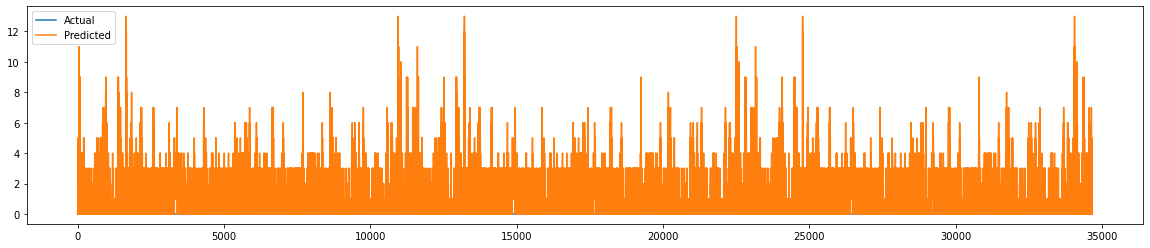

In [16]:
plt.figure(figsize=(20, 4))

plt.plot(industry_data_encoded[industry_data_encoded['Datetime'] >= set_dt]['Industry Size'].reset_index(drop=True), label='Actual',)
plt.plot(y_pred_r, label='Predicted')



plt.legend()
plt.show();

In [17]:
newlist = list(industry_data_encoded[industry_data_encoded['Datetime']<set_dt]['Industry Size'])+y_pred_r
industry_data_encoded['Industry Size'] = newlist

In [ ]:
result = pd.DataFrame([])
result['predicted'] = y_pred_r
#***
#result.to_csv("1108순차.csv",index=False)